# Please Switch your kernel (under kernel tab) to bayesian-net

In [1]:
from pgmpy.models import BayesianModel,BayesianNetwork 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score, mean_squared_error,precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, ExpectationMaximization, IVEstimator
from pgmpy.inference import VariableElimination, BeliefPropagation
import bnlearn as bn
import networkx as nx
import graphviz
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Read Data

In [2]:
crash = pd.read_csv('data/crash_BNExamples.csv').reset_index().iloc[:,1:]
crash = crash.loc[(crash['Duration (min)']>0)&(crash['Duration (min)']<=150)].reset_index()
crash['Duration_class'] = pd.cut(crash['Duration (min)'], [0,30,60,90,120], right=True, labels=[0,1,2,3])
crash = crash.dropna()
#target_var = 'Duration (min)'
target_var = 'Duration_class'

column_clear = ['Start Date Time','Direction','County', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', target_var]

crash['Start Date Time'] = pd.to_datetime(crash['Start Date Time'])

data = crash[crash['Start Date Time'].dt.year.isin([2021])].iloc[:,1:]

data = data[column_clear].iloc[:,1:]

In [3]:
train, test = train_test_split(data, test_size=0.25)

In [4]:
train_target = train.pop('Duration_class')

In [5]:
Xtrain, Xval, ytrain, yval = train_test_split(train, train_target, test_size=0.1, random_state=0)
valid = pd.concat([Xval, yval], axis='columns')
dfnum = pd.concat([Xtrain, ytrain], axis='columns')
dfnum

,Direction,County,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration_class
3565,4,2,0,1,0,2,1,1,1,0,1
684,1,2,0,0,0,1,0,0,1,0,0
5928,3,2,0,0,0,2,1,1,1,1,3
1946,1,2,0,0,0,2,0,0,1,0,0
490,2,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
61,1,1,0,1,0,1,0,0,1,0,0
402,1,4,0,1,0,0,0,0,1,0,0
5050,3,3,0,1,1,0,0,1,1,1,2
164,4,2,1,0,0,1,0,0,2,0,0


# Define Performance Metric: Accuracy Score, Precision, Recall, F1-Measurement

In [6]:
#Get accuracy for classification task
def get_acc(model, df, col):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = accuracy_score(df[col], pred)
    print('Accuracy -', acc)
    return acc

In [7]:
def get_acc_label(model, df, col, labels):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = precision_recall_fscore_support(df[col], pred, average=None, labels=labels)
    print('precision, recall, f1 -', acc)
    return acc

# Bayesian Network

# Structure Learning

In [10]:
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='cl', root_node='Duration_class', bw_list_method='nodes', verbose=3)
#DAG = bn.structure_learning.fit(data,methodtype='cl', scoretype='bdeu')
#DAG = bn.structure_learning.fit(data,methodtype='naivebayes', scoretype='bdeu', root_node='Duration_class')


[bnlearn] >Warning: Computing DAG with 11 nodes can take a very long time!
[bnlearn] >Computing best DAG using [chow-liu]


Building tree:   0%|          | 0/55.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).


In [11]:
#model.edges()
DAG['model_edges']

[('Duration_class', 'Truck involved'),
 ('Duration_class', 'Injury involved'),
 ('Duration_class', 'Fire involved'),
 ('Duration_class', 'Direction'),
 ('Direction', 'County'),
 ('Direction', 'Lane Closure Type'),
 ('Lane Closure Type', 'TOD'),
 ('Lane Closure Type', 'MonthofYear'),
 ('TOD', 'PeakHour'),
 ('TOD', 'DayofWeek')]

In [12]:
#Define plotting method for hierarchy graph

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = 2*dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

## Plot Learned Structure in two ways, directed and undirected graph

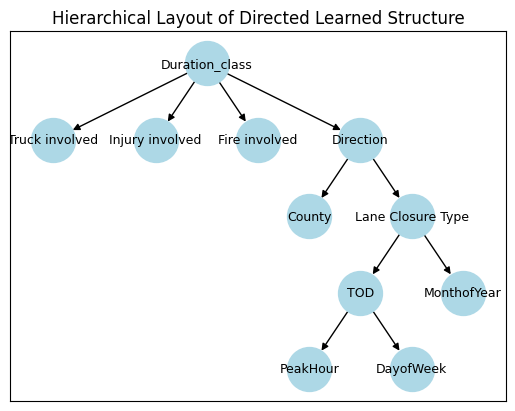

In [13]:
# Plot directed hierarchical graph
#G = bn.plot(DAG)
# Convert Bayesian network structure to a hierarchical structure (DAG)
G = nx.DiGraph()
#G.add_edges_from(model.edges())
G.add_edges_from(DAG['model_edges'])

# Plot the hierarchical structure
plt.title('Hierarchical Layout of Directed Learned Structure')
pos = hierarchy_pos(G) 
nx.draw_networkx(G, pos, with_labels=True, arrows=True, node_color="lightblue", node_size=1000, font_size=9)

plt.savefig('BN_structure_directed.png')

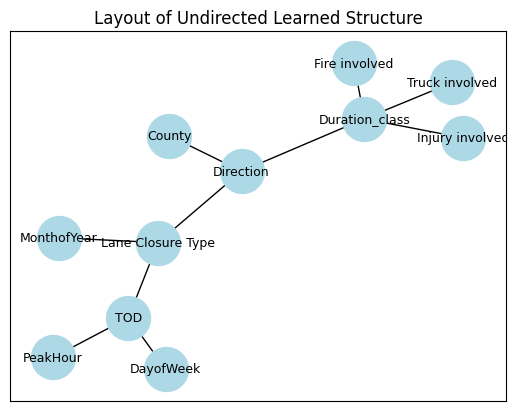

In [14]:
# Plot directed hierarchical graph
G = nx.Graph()
#G.add_edges_from(model.edges())
G.add_edges_from(DAG['model_edges'])

# Plot the hierarchical structure
plt.title('Layout of Undirected Learned Structure')
nx.draw_networkx(G, with_labels=True, arrows=True, node_color="lightblue", node_size=1000, font_size=9)

plt.savefig('BN_structure_undirected.png')

# Parameter Learning

In [15]:
# Parameter learning
model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);
model = BayesianNetwork(ebunch=DAG['model_edges'])
bayes = BayesianEstimator(model=model, data = data)
model.fit(dfnum, estimator=BayesianEstimator, prior_type='BDeu',equivalent_sample_size=10,
          complete_samples_only=False)
model.local_independencies(bayes.variables)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Duration_class:
+-------------------+----------+
| Duration_class(0) | 0.397286 |
+-------------------+----------+
| Duration_class(1) | 0.302503 |
+-------------------+----------+
| Duration_class(2) | 0.180203 |
+-------------------+----------+
| Duration_class(3) | 0.120008 |
+-------------------+----------+
[bnlearn] >CPD of Truck involved:
+-------------------+-----+---------------------+
| Duration_class    | ... | Duration_class(3)   |
+-------------------+-----+---------------------+
| Truck involved(0) | ... | 0.19904458598726116 |
+-------------------+-----+---------------------+
| Truck involved(1) | ... | 0.8009554140127388  |
+-------------------+-----+---------------------+
[bnlearn] >CPD of Injury involved:
+--------------------+-----+---------------------+
| Dur

(Direction ⟂ Truck involved, Injury involved, Fire involved | Duration_class)
(County ⟂ Injury involved, Fire involved, Duration_class, Lane Closure Type, PeakHour, TOD, MonthofYear, Truck involved, DayofWeek | Direction)
(TOD ⟂ Direction, MonthofYear, Injury involved, Duration_class, Fire involved, County, Truck involved | Lane Closure Type)
(PeakHour ⟂ Direction, Injury involved, Fire involved, Duration_class, Lane Closure Type, MonthofYear, County, Truck involved, DayofWeek | TOD)
(DayofWeek ⟂ Direction, Injury involved, Fire involved, Duration_class, Lane Closure Type, PeakHour, MonthofYear, County, Truck involved | TOD)
(MonthofYear ⟂ Direction, Injury involved, Fire involved, Duration_class, PeakHour, TOD, County, Truck involved, DayofWeek | Lane Closure Type)
(Injury involved ⟂ Direction, Fire involved, Lane Closure Type, PeakHour, TOD, MonthofYear, County, Truck involved, DayofWeek | Duration_class)
(Truck involved ⟂ Direction, Injury involved, Fire involved, Lane Closure Type,

# Validation

In [38]:
acc1 = get_acc(model, valid, 'Duration_class')

  0%|          | 0/375 [00:00<?, ?it/s]

     Duration_class
0                 1
1                 1
2                 2
3                 1
4                 1
..              ...
466               1
467               0
468               0
469               0
470               1

[471 rows x 1 columns]
Accuracy - 0.921443736730361


In [39]:
acc2 = get_acc_label(model, valid, 'Duration_class', [0,1,2,3])

  0%|          | 0/375 [00:00<?, ?it/s]

     Duration_class
0                 1
1                 1
2                 2
3                 1
4                 1
..              ...
466               1
467               0
468               0
469               0
470               1

[471 rows x 1 columns]
precision, recall, f1 - (array([0.97969543, 0.9205298 , 0.98      , 0.7260274 ]), array([0.95073892, 0.9858156 , 0.67123288, 0.98148148]), array([0.965     , 0.95205479, 0.79674797, 0.83464567]), array([203, 141,  73,  54]))


# Inference: Dealing with Missing Information

### BN predicts the TID based on probabilistic inference, which is capable of dealing with missing information. The following two scenarios show the prediction of TID with some missing variables.

## Scenario#1: Predicting TID with missing Fire Truck Involvement information

In [40]:
#Inference with complete information
inference = VariableElimination(model)
# evidence = valid.iloc[0,:-1]
# result=inference.query(variables=['Duration_class'], evidence=evidence)
# print(result)

In [41]:
#Inference with missing Fire Truck Involvement information
evidence = {'Direction':4, 
            'County': 3, 
            'TOD': 0, 
            'PeakHour': 1, 
            'DayofWeek': 0, 
            'MonthofYear': 1,
           'Injury involved': 1,
           'Truck involved': 1,
           'Lane Closure Type': 1}
           #'Fire involved': 0}
result=inference.query(variables=['Duration_class'], evidence=evidence)
print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0002 |
+-------------------+-----------------------+
| Duration_class(1) |                0.6373 |
+-------------------+-----------------------+
| Duration_class(2) |                0.1402 |
+-------------------+-----------------------+
| Duration_class(3) |                0.2223 |
+-------------------+-----------------------+


## Scenario#2: Predicting TID with missing Fire Truck and Injury information

In [42]:
#Inference with missing Fire Involvement and Injury information
evidence = {'Direction':4, 
            'County': 3, 
            'TOD': 0, 
            'PeakHour': 1, 
            'DayofWeek': 0, 
            'MonthofYear': 1,
            #'Injury involved': 1,
           'Truck involved': 1,
           'Lane Closure Type': 1
           #'Fire involved': 0
           }
result=inference.query(variables=['Duration_class'], evidence=evidence)
print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0046 |
+-------------------+-----------------------+
| Duration_class(1) |                0.5098 |
+-------------------+-----------------------+
| Duration_class(2) |                0.3077 |
+-------------------+-----------------------+
| Duration_class(3) |                0.1778 |
+-------------------+-----------------------+


# Decision-making using probabilistic inference

### The probabilistic inference in BN also enables to manipulate the certainty in the selected variables, thereby ensuring the creation of scenario-based network structure

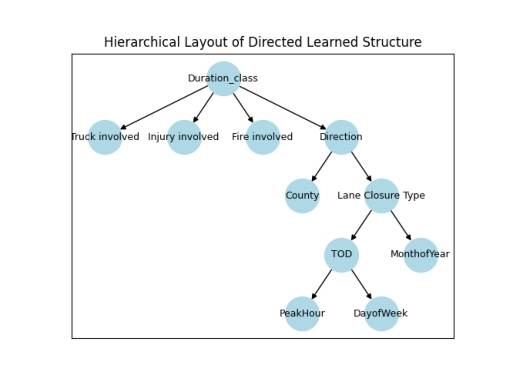

In [50]:
img=mpimg.imread('BN_structure_directed.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [51]:
evidence = {'Injury involved': 1,
           'Truck involved': 1,
           'Lane Closure Type': 1,
           'Fire involved': 1}
model.nodes()
for node in model.nodes():
    if node not in evidence:
        result=inference.query(variables=[node], evidence=evidence)
        print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0000 |
+-------------------+-----------------------+
| Duration_class(1) |                0.2344 |
+-------------------+-----------------------+
| Duration_class(2) |                0.2979 |
+-------------------+-----------------------+
| Duration_class(3) |                0.4677 |
+-------------------+-----------------------+
+--------------+------------------+
| Direction    |   phi(Direction) |
+==============+==================+
| Direction(1) |           0.2457 |
+--------------+------------------+
| Direction(2) |           0.2794 |
+--------------+------------------+
| Direction(3) |           0.2487 |
+--------------+------------------+
| Direction(4) |           0.2229 |
+--------------+------------------+
| Direction(5) |           0.0033 |
+--------------+------------------+
+-----------+-------------

# Prediction

In [52]:
result_pred = model.predict(test.iloc[:,:-1])

  0%|          | 0/913 [00:00<?, ?it/s]

In [53]:
acc_test=accuracy_score(test['Duration_class'], result_pred)
acc_label_test=precision_recall_fscore_support(test['Duration_class'], result_pred, labels=[0,1,2,3])
print("Test accuracy score -", acc_test)
print("Test precision, recall, F1-score and Sample Size -", acc_label_test)

Test accuracy score - 0.9254302103250478
Test precision, recall, F1-score and Sample Size - (array([0.99383667, 0.9351145 , 1.        , 0.63425926]), array([0.95132743, 1.        , 0.68181818, 1.        ]), array([0.97211756, 0.96646943, 0.81081081, 0.77620397]), array([678, 490, 264, 137]))


In [54]:
test['Duration_class']
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3])
ypred = label_binarize(result_pred, classes=[0,1,2,3])

# TPR, FPR and AUC

In [57]:
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3])
fpr, tpr = dict(), dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest[:,i], ypred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# for i in range(n_classes):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0,1],[0,1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.04])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('AUC-ROC for TID (Duration Class=%0.0f)' % i)
#     plt.legend(loc='lower right')
#     plt.show()
#     plt.savefig('AUC_ROC for TID (Duration Class=%0.0f).png' %i)

In [58]:
roc_auc
tpr
fpr[0][1]
for i in range(n_classes):
    print("Class {}: true positive rate (TPR) is {:.2f}, false positive rate (FPR) is {:.2f}, AUC score is {:.2f}".format(i, tpr[i][1], fpr[i][1], roc_auc[i]))

Class 0: true positive rate (TPR) is 0.95, false positive rate (FPR) is 0.00, AUC score is 0.97
Class 1: true positive rate (TPR) is 1.00, false positive rate (FPR) is 0.03, AUC score is 0.98
Class 2: true positive rate (TPR) is 0.68, false positive rate (FPR) is 0.00, AUC score is 0.84
Class 3: true positive rate (TPR) is 1.00, false positive rate (FPR) is 0.06, AUC score is 0.97


| TID Class | TPR | FPR | AUC |
| --- | --- | --- | --- |
| Class 0 (0-30 min) | 0.95 | 0 | 0.97 |
| Class 1 (30-60 min) | 1.00 | 0.03 | 0.98 |
| Class 2 (60-90 min) | 0.68 | 0 | 0.84 |
| Class 3 (Larger than 90 min) | 1.00 | 0.06 | 0.97 |